In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

### You need to get your own license file from Gurobi's website ! It is for single machine use only ! 

In [2]:
import os
import gurobipy as gp

# Set the GRB_LICENSE_FILE environment variable to the correct license file path
os.environ["GRB_LICENSE_FILE"] = "/Users/emrekuru/Developer/Production_Planning/gurobi.lic"

In [3]:
model = gp.Model("PaintingProcessOptimization")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-11


In [4]:
# Parameters
num_parts = 10     # Number of parts
demand = {p: 4 for p in range(1, num_parts + 1)}  

parts_colors = {
    1: 'Red',
    2: 'Blue',
    3: 'Green',
    4: 'Yellow',
    5: 'Black',
    6: 'Red',
    7: 'Blue',
    8: 'Green',
    9: 'Yellow',
    10: 'Black'
}

color_cost = {
    'Red': 10,
    'Blue': 10,
    'Green': 10,
    'Yellow': 10,
    'Black': 10
}

unit_production_time = {
    1: 1,   
    2: 1,   
    3: 1,   
    4: 1,   
    5: 1,   
    6: 1,   
    7: 1,   
    8: 1,   
    9: 1,
    10: 1
}

max_time = 24

In [5]:
parts_colors

{1: 'Red',
 2: 'Blue',
 3: 'Green',
 4: 'Yellow',
 5: 'Black',
 6: 'Red',
 7: 'Blue',
 8: 'Green',
 9: 'Yellow',
 10: 'Black'}

In [6]:
machines = [1,2]
# Define continuous variables for start and end times of production for each part
start_times = model.addVars(range(1, num_parts + 1), vtype=GRB.CONTINUOUS, name="start_times")
end_times = model.addVars(range(1, num_parts + 1), vtype=GRB.CONTINUOUS, name="end_times")

# Define binary variable to indicate the order of parts on each machine
# order[p, p_prime, m] = 1 if part p is scheduled before part p_prime on machine m
order = model.addVars(range(1, num_parts + 1), range(1, num_parts + 1), machines, vtype=GRB.BINARY, name="order")

# Define binary variable to indicate successor relationship for each machine
# successor[p, p_prime, m] = 1 if part p is the immediate predecessor of part p_prime on machine m
successor = model.addVars(range(1, num_parts + 1), range(1, num_parts + 1), machines, vtype=GRB.BINARY, name="successor")

# Define binary variable for color change costs on each machine
# color_change[p, p_prime, m] = 1 if there is a color change between part p and part p_prime on machine m
color_change = model.addVars(range(1, num_parts + 1), range(1, num_parts + 1), machines, vtype=GRB.BINARY, name="color_change")

# Define binary variables for machine assignments: machine_assignment[p, m] = 1 if part p is assigned to machine m
machine_assignment = model.addVars(range(1, num_parts + 1), machines, vtype=GRB.BINARY, name="machine_assignment")

In [7]:
model.setObjective(
    quicksum(
        color_cost[parts_colors[p]] * color_change[p, q, m]
        for p in range(1, num_parts + 1)
        for q in range(1, num_parts + 1)
        for m in machines
    ),
    GRB.MINIMIZE
)


In [8]:
big_M = 1e6

# Ensure each part has at most one immediate successor, with exactly one part having no successor (the end part) per machine
for p in range(1, num_parts + 1):
    for m in machines:
        model.addConstr(
            quicksum(successor[p, q, m] for q in range(1, num_parts + 1) if q != p) <= machine_assignment[p, m],
            name=f"Single_Successor_{p}_Machine_{m}"
        )

# Ensure each part has at most one immediate predecessor, with exactly one part having no predecessor (the start part) per machine
for q in range(1, num_parts + 1):
    for m in machines:
        model.addConstr(
            quicksum(successor[p, q, m] for p in range(1, num_parts + 1) if p != q) <= machine_assignment[q, m],
            name=f"Single_Predecessor_{q}_Machine_{m}"
        )

# Ensure exactly one part without a successor (the end part) per machine
for m in machines:
    model.addConstr(
        quicksum(quicksum(successor[p, q, m] for q in range(1, num_parts + 1) if q != p) for p in range(1, num_parts + 1)) 
        == quicksum(machine_assignment[p, m] for p in range(1, num_parts + 1)) - 1,
        name=f"Total_Successors_Machine_{m}"
    )

# Ensure mutual exclusivity in ordering between each pair of parts on the same machine
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime:
            for m in machines:
                model.addConstr(
                    order[p, p_prime, m] + order[p_prime, p, m] == machine_assignment[p, m] * machine_assignment[p_prime, m],
                    name=f"Order_Binary_{p}_{p_prime}_Machine_{m}"
                )

# Link the immediate successor relationship to the order variable for parts on the same machine
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime:
            for m in machines:
                model.addConstr(
                    order[p_prime, p, m] >= successor[p, p_prime, m],
                    name=f"Order_Successor_Link_{p_prime}_{p}_Machine_{m}"
                )

# Ensure color change costs are applied when there is a change in color between successive parts on the same machine
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime and parts_colors[p] != parts_colors[p_prime]:
            for m in machines:
                model.addConstr(
                    color_change[p_prime, p, m] >= successor[p, p_prime, m],
                    name=f"Color_Change_{p}_{p_prime}_Machine_{m}"
                )

# Demand fulfillment constraints to ensure each part meets its demand
for p in range(1, num_parts + 1):
    model.addConstr(
        (end_times[p] - start_times[p]) * unit_production_time[p] >= demand[p],
        name=f"Demand_Fulfillment_{p}"
    )

# Ensure each part is assigned to exactly one machine
for p in range(1, num_parts + 1):
    model.addConstr(
        quicksum(machine_assignment[p, m] for m in machines) == 1,
        name=f"Machine_Assignment_{p}"
    )

# Non-overlap constraint for parts on the same machine using big-M
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime:
            for m in machines:
                model.addConstr(
                    end_times[p] <= start_times[p_prime] + big_M * (1 - order[p, p_prime, m]),
                    name=f"No_Overlap_Same_Machine_{p}_{p_prime}_Machine_{m}"
                )

# Ensure no part's end time exceeds the maximum allowed time
for p in range(1, num_parts + 1):
    model.addConstr(
        end_times[p] <= max_time,
        name=f"Max_Time_Limit_{p}"
    )


In [9]:
# Set model parameters if necessary, e.g., setting the feasibility tolerance
model.setParam("IntFeasTol", 1e-9)
model.setParam("Threads", 16) 



# Optimize the model
model.optimize()

Set parameter IntFeasTol to value 1e-09
Set parameter Threads to value 16
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 16 threads

         Reduce the value of the Threads parameter to improve performance


Optimize a model with 592 rows, 640 columns and 1870 nonzeros
Model fingerprint: 0x5708abff
Model has 180 quadratic constraints
Variable types: 20 continuous, 620 integer (620 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 7 rows and 260 columns
Presolve time: 0.03s
Presolved: 701 rows, 409 columns, 2400 nonzeros
Variable types: 10 continuous, 399 integer (399 binary)

Root relaxation: objective 3.000000e+01, 507 iterations, 0.01 seconds (0.01 work units)



In [10]:
start_times

{1: <gurobi.Var start_times[1] (value 8.0)>,
 2: <gurobi.Var start_times[2] (value 16.0)>,
 3: <gurobi.Var start_times[3] (value 8.0)>,
 4: <gurobi.Var start_times[4] (value 20.0)>,
 5: <gurobi.Var start_times[5] (value 4.0)>,
 6: <gurobi.Var start_times[6] (value 12.0)>,
 7: <gurobi.Var start_times[7] (value 20.0)>,
 8: <gurobi.Var start_times[8] (value 12.0)>,
 9: <gurobi.Var start_times[9] (value 16.0)>,
 10: <gurobi.Var start_times[10] (value 0.0)>}

In [11]:
end_times

{1: <gurobi.Var end_times[1] (value 12.0)>,
 2: <gurobi.Var end_times[2] (value 20.0)>,
 3: <gurobi.Var end_times[3] (value 12.0)>,
 4: <gurobi.Var end_times[4] (value 24.0)>,
 5: <gurobi.Var end_times[5] (value 8.0)>,
 6: <gurobi.Var end_times[6] (value 16.0)>,
 7: <gurobi.Var end_times[7] (value 24.0)>,
 8: <gurobi.Var end_times[8] (value 16.0)>,
 9: <gurobi.Var end_times[9] (value 20.0)>,
 10: <gurobi.Var end_times[10] (value 4.0)>}

In [12]:
# Check if the model is infeasible
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible. Computing IIS...")
    model.computeIIS()
    model.write("model.ilp")
    
    # Print the constraints that are part of the IIS
    print("\nThe following constraints are part of the IIS:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(f"{c.constrName}")

Optimal solution found:
Minimized Total Cost (Objective Value): 30.0


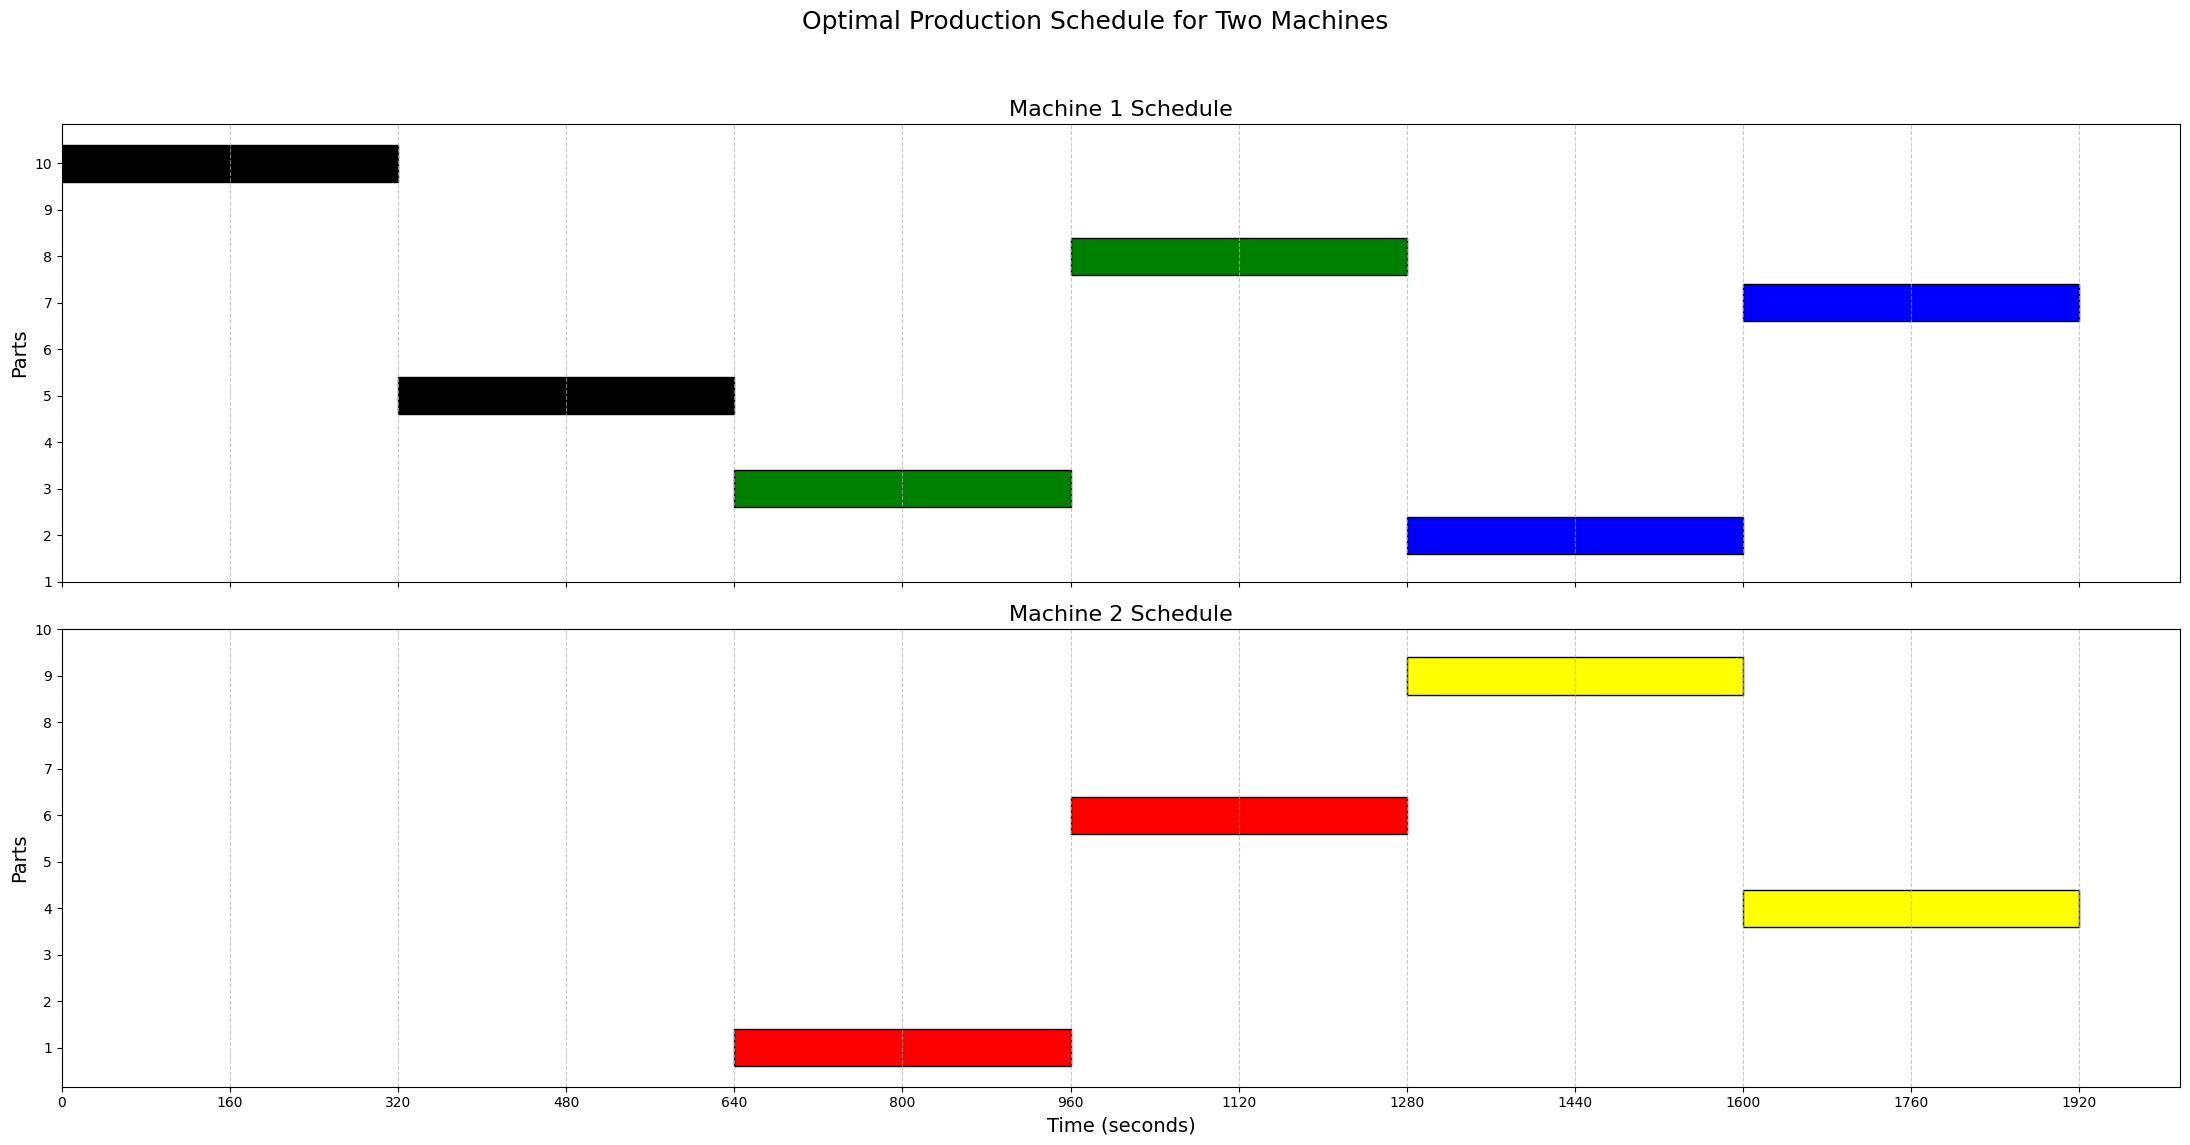

In [13]:
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    
    # Display objective function result
    minimized_cost = model.ObjVal
    print(f"Minimized Total Cost (Objective Value): {minimized_cost}")

    # Extract start and end times for each part assigned to each machine
    start_times_values = {p: start_times[p].X for p in range(1, num_parts + 1)}
    end_times_values = {p: end_times[p].X for p in range(1, num_parts + 1)}

    # Plotting the Gantt chart with two subplots for Machine 1 and Machine 2
    fig, axs = plt.subplots(2, 1, figsize=(22, 12), sharex=True)
    
    # Define color mapping for the parts
    color_map = {
        'Red': 'red',
        'Blue': 'blue',
        'Green': 'green',
        'Yellow': 'yellow',
        'Black': 'black',
        'Purple': 'purple',
        'Orange': 'orange'
    }

    # Iterate through parts to plot on the appropriate machine's subplot
    for m in machines:
        ax = axs[m - 1]  # Subplot for each machine (Machine 1 and Machine 2)
        for p in range(1, num_parts + 1):
            # Check if part p is assigned to machine m
            if machine_assignment[p, m].X > 0.5:  # Assigned to machine m
                part_color = color_map[parts_colors[p]]
                # Plot part p on machine m's subplot
                ax.barh(p, (end_times_values[p] - start_times_values[p]) * 80, 
                        left=start_times_values[p] * 80, color=part_color,
                        edgecolor='black', label=parts_colors[p] if p == 1 else "")
                
        # Customize each subplot
        ax.set_title(f"Machine {m} Schedule", fontsize=16)
        ax.set_ylabel("Parts", fontsize=14)
        ax.set_yticks(range(1, num_parts + 1))
        ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Set common labels
    plt.xlabel("Time (seconds)", fontsize=14)
    plt.xticks(np.arange(0, (max(end_times_values.values()) + 1) * 80, 160))  # Adjust x-tick intervals for seconds
    fig.suptitle("Optimal Production Schedule for Two Machines", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for title space

    # Save the plot as an image file
    plt.savefig("optimal_production_schedule.png")
else:
    print("No optimal solution found.")
